# __SpringBoard Capstone Project 2: Human Activity Recognition__
## __Deep Learning__

__Written by: Sofy Weisenberg__<br>
__Date: 04/21/20__

__Importing the Data__<br>
In previous sections, the dataset used had undergone feature engineering (with 9 signal time series transformed into 561 features for each 2.56 s window of the time series). Implementing a deep learning approach will require switching to the raw data in order to allow the network to find its own features in the data. 

Therefore, the raw data will need to be loaded into an appropriately sized feature array X. The label vector y from previous sections remains the same. 

Each row/observation still represents a single 2.56 s window, and these windows still have 50% overlap per the design of the collected data. However, now each row contains 128 time steps of raw signal data (50 Hz x 2.56 s). A row with 128 columns exists for each of the 9 signal channels:

- body acceleration (x,y,z)
- body gyroscope (x,y,z)
- total acceletation (x,y,z)

Therefore, when combining all the signal data, each row should actually have 128 x 9 = 1152 columns or features. The 9 channels of data are stored in 9 separate files and are already separated into training and test sets (see "Splitting the Data: Training and Test Sets" in the previous section).

__Categorical Class Encoding__

Since the class labels (Activity column) for this data are in a categorical string format, they must first be encoded to a numerical format useable for supervised machine learning. Simple integer encoding (i.e. translating each class label into an integer label 1-6) would not be effective on its own in this case, since such an encoding implies an ordinal relationship between the classes, where in reality there is none. This may result in poor model performance or unexpected results.

Integer encoding followed by one-hot encoding is the preferred method to transform the categorical data. Each integer class label is assigned to a new binary (0/1) column of "dummy variables". Each observation in the dataset is then be labeled with a 1 in only one of these "dummy variable" columns and the rest are labeled with a 0, resulting in sparse matrices of class labels for y_train and y_test. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import time
import tensorflow as tf
from tensorflow import keras

# Use the current working directory path to navigate to the location of the processed data
cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, '..', 'data', 'raw')

# Throw an assert error if the path does not exist
assert os.path.exists(data_path)

The code for loading the data was modified from the guide found here:
https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

In [2]:
# load a single file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

In [3]:
# load all channels into a stacked 3D array
def load_files_3D_array(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(os.path.join(prefix, name))
        loaded.append(data)
    
    # stack array so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [4]:
# load a dataset group, specify group = 'train' or 'test', prefix is location of group data folder
def load_dataset_group(group, prefix=''):
    
    filepath = os.path.join(prefix, group, 'Inertial Signals')
    
    # list all 9 filenames in group (train/test)
    filenames = list()
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    
    # load 3D stacked feature array for group (train/test)
    X = load_files_3D_array(filenames, filepath)
    # load class output array for group (train/test)
    y = load_file(os.path.join(prefix, group, 'y_'+group+'.txt'))
    
    return X, y

In [5]:
from tensorflow.keras.utils import to_categorical

# load the entire dataset, prefix is filepath of dataset folder
# returns train and test stacked feature array X and class output array y (one-hot encoded) for train, test groups
def load_dataset(prefix=''):
    
    # load all training set
    X_train, y_train = load_dataset_group('train', prefix)
    
    # load all test set
    X_test, y_test = load_dataset_group('test', prefix)
    
    # zero-offset class values (transform integers 1-6 to integers 0-5 for one-hot encoding)
    y_train = y_train - 1
    y_test = y_test - 1
    # one hot encode y
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    print('Training feature array X size, training label vector y size:')
    print(X_train.shape, y_train.shape)
    print('\nTest feature array X size, test label vector y size:')
    print(X_test.shape, y_test.shape)
    
    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = load_dataset(data_path)

Training feature array X size, training label vector y size:
(7352, 128, 9) (7352, 6)

Test feature array X size, test label vector y size:
(2947, 128, 9) (2947, 6)


__Feature Scaling__<br>
To improve performance of the machine learning model(s) to be applied to this classification problem, first the feature data should be appropriately scaled.

Scaling must be performed both on the training and test data sets in the same manner. Best practice is to use only the training set to identify the correct scaling, and then blindly apply the same transformation to the test set. Scaling all features to a [0,1] range is a common scaling method for neural network preprocessing and may be applied using the MinMaxScaler() transformation method from sklearn. 

However, after evaluating the model with [0,1] scaling, poor performance was observed (approx. 0.78 accuracy). MinMaxScaler() with range [1,1] scaling performed much better (approx. 0.89 accuracy) and StandardScaler() with mean centered around 0 and std. dev = 1 performed even slightly better (approx. 0.91 accuracy). Therefore, the StandardScaler() method was selected for feature scaling.

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# initialize scaled feature arrays 
X_train_scaled = np.empty(X_train.shape)
X_test_scaled = np.empty(X_test.shape)

# initialize scaler function
scaler = StandardScaler()

# scaler only accepts 2D arrays, so loop over 9 2D arrays to fit and transform accordingly for each
for i in range(X_train.shape[2]):
    scaler.fit(X_train[:,:,i])
    X_train_scaled[:,:,i] = scaler.transform(X_train[:,:,i])
    X_test_scaled[:,:,i] = scaler.transform(X_test[:,:,i])

The scaling transformation has been performed successfully on both the training and test feature sets. <br>
- The mean for each column in the X_train_scaled feature array is 0, and std. dev is 1. <br>
- The mean for each column in the X_test_scaled feature array is NOT 0, and std. dev is NOT 1, since a transformation matrix (generated from normalizing the training feature matrix range) was applied to the test feature matrix.

__Fitting an RNN Model__<br>
Now that the data has been loaded and preprocessing completed, a deep learning model may be trained on the data. The first model that will be implemented is a Recurrent Neural Network (RNN) which leverages the sequential nature of the time series signal data from the 9 different channels. Specifically, the LSTM (long short term memory) layer of the neural network, unlike feed forward neural network architectures, has feedback mechanisms that allow previous observations in the sequence to be "remembered" by the network.

First, a basic network architecture will be established. Then several network hyperparameters will be optimized using a grid search optimization. 

In [8]:
# Use scikit-learn to grid search the network hyperparameters
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Function to create model, required for KerasClassifier

def create_RNN_model(neurons=100, dropout=0.5, batch_size=64):
    # Define key array lengths 
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    
    # Define input layer and hidden layers
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, kernel_initializer='glorot_uniform', activation='relu'))
    
    # Define output layer with multiple outputs and compile model
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# initialize model and early stopping monitor (if model convergence reached before n_epochs)
n_epochs = 35
RNN_model = KerasClassifier(build_fn=create_RNN_model, verbose=0, epochs=n_epochs)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# define the grid search parameters
neurons = [50, 100, 200]
dropout = [0.1,0.3,0.5]
batch_size = [32, 64, 128]

param_grid = dict(neurons=neurons, 
                  dropout=dropout, 
                  batch_size=batch_size)

# setup grid search
RNN_grid = GridSearchCV(estimator=RNN_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=1)

In [10]:
import pickle

# load grid search results from file if previously run (to avoid long runtime)
if os.path.exists('..\data\interim\RNN_grid_result_best_score_.pickle'):
    with open('..\data\interim\RNN_grid_result_best_score_.pickle', 'rb') as f:
        RNN_grid_result_best_score_ = pickle.load(f)
    with open('..\data\interim\RNN_grid_result_best_params_.pickle', 'rb') as f:
        RNN_grid_result_best_params_ = pickle.load(f)
    with open('..\data\interim\RNN_grid_result_cv_results_.pickle', 'rb') as f:
        RNN_grid_result_cv_results_ = pickle.load(f)
else:
    # fit the grid search models, report results with early stopping callback, and pickle the result
    # note: grid_result itself cannot be pickled, so it must be broken down to subvariables and pickled 
    RNN_grid_result = RNN_grid.fit(X_train_scaled, y_train, callbacks=[es], validation_split=0.20)
    
    with open('..\data\interim\RNN_grid_result_best_score_.pickle', 'wb') as f:
        pickle.dump(RNN_grid_result.best_score_, f)
    with open('..\data\interim\RNN_grid_result_best_params_.pickle', 'wb') as f:
        pickle.dump(RNN_grid_result.best_params_, f)
    with open('..\data\interim\RNN_grid_result_cv_results_.pickle', 'wb') as f:
        pickle.dump(RNN_grid_result.cv_results_, f)
    
    RNN_grid_result_best_score_ = RNN_grid_result.best_score_ 
    RNN_grid_result_best_params_ = RNN_grid_result.best_params_
    RNN_grid_result_cv_results_ = RNN_grid_result.cv_results_
        

In [11]:
# summarize grid search results and report best parameter set
print("Best: %f using %s" % (RNN_grid_result_best_score_, RNN_grid_result_best_params_))
means = RNN_grid_result_cv_results_['mean_test_score']
stds = RNN_grid_result_cv_results_['std_test_score']
params = RNN_grid_result_cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.934711 using {'batch_size': 128, 'dropout': 0.1, 'neurons': 200}
0.910768 (0.025394) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 50}
0.927502 (0.014116) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 100}
0.901934 (0.026463) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 200}
0.921245 (0.010107) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 50}
0.907778 (0.027478) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 100}
0.926822 (0.017159) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 200}
0.893356 (0.037701) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 50}
0.914577 (0.024421) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 100}
0.918118 (0.016523) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 200}
0.926687 (0.001157) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 50}
0.928316 (0.016770) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 100}
0.927366 (0.002975) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 200}
0.90764

Now that the best parameter set has been identified, a model with these parameters will be fit to the training data and evaluated. The training history will be plotted to visualize the validation accuracy and loss vs. the progression of the epochs. This shows model convergence and can hint at overfitting. A confusion matrix then shows the model's overall performance across classes.

In [12]:
# Define function to plot the training history (accuracy and loss for the training and validation sets)
def show_train_history(train_history,n_epochs,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History: %i epochs' % n_epochs)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.xticks(np.arange(0, n_epochs, step=round(n_epochs/10)))
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [13]:
# initialize a model with the best parameters from the grid search
start_time = time.time()
RNN_model = create_RNN_model(neurons=RNN_grid_result_best_params_['neurons'], 
                             dropout=RNN_grid_result_best_params_['dropout'], 
                             batch_size=RNN_grid_result_best_params_['batch_size'])

# show a summary of the model network architechture and output shape from each layer
print(RNN_model.summary())

# fit the model and output the training history so it may be plotted
RNN_model_train_history = RNN_model.fit(x=X_train_scaled, y=y_train,  
                          validation_split=0.20, 
                          epochs=n_epochs, 
                          batch_size=RNN_grid_result_best_params_['batch_size'], 
                          verbose=2,
                          callbacks=[es])

print("\n--- Training executed in %s seconds ---" % (time.time() - start_time))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               168000    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1206      
Total params: 209,406
Trainable params: 209,406
Non-trainable params: 0
_________________________________________________________________
None
Train on 5881 samples, validate on 1471 samples
Epoch 1/35
5881/5881 - 13s - loss: 0.8735 - accuracy: 0.6752 - val_loss: 0.3561 - val_accuracy: 0.8817
Epoch 2/35
5881/5881 - 12s - loss: 0.2462 - accuracy: 0.9117 - val_loss: 0.3118 - val_accura

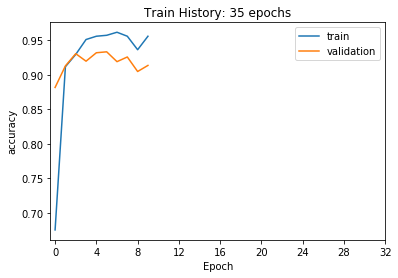

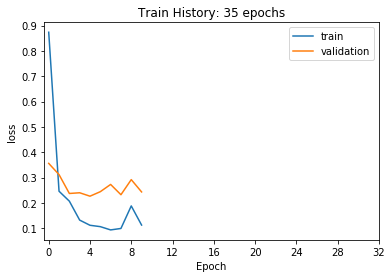

In [14]:
show_train_history(RNN_model_train_history,n_epochs,'accuracy','val_accuracy')
show_train_history(RNN_model_train_history,n_epochs,'loss','val_loss')

In [15]:
# define function for creating labeled confusion matrix for multiclass identification
def labeled_confusion_mat(true_vector, pred_vector, labels):
    confusion_matrix_labeled = pd.DataFrame(confusion_matrix(true_vector, pred_vector))
    confusion_matrix_labeled.columns = list(labels)
    confusion_matrix_labeled.index = list(labels)
    return confusion_matrix_labeled

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# evaluate RNN model on test set using .predict() and then revert to integer class label encoding
start_time = time.time()
y_test_pred_encoded = RNN_model.predict(X_test_scaled)
print("--- RNN model prediction executed in %s seconds ---" % (time.time() - start_time))
y_test_pred = np.argmax(y_test_pred_encoded, axis =1)
y_test_act = np.argmax(y_test, axis =1)

labels = ['LAY', 'SIT', 'STA', 'WALK', 'WALK_D', 'WALK_U']
print('\nConfusion matrix for RNN evaluation on test set:\n')
print(labeled_confusion_mat(y_test_act, y_test_pred, labels))
print('\nClassification report for RNN evaluation on test set:\n')
print(classification_report(y_test_act, y_test_pred, target_names=labels))

--- RNN model prediction executed in 2.483363628387451 seconds ---

Confusion matrix for RNN evaluation on test set:

        LAY  SIT  STA  WALK  WALK_D  WALK_U
LAY     470    2   24     0       0       0
SIT       8  437   26     0       0       0
STA       8    7  405     0       0       0
WALK      1   26    0   375      89       0
WALK_D   10    3    0    59     460       0
WALK_U    0   27    0     0       0     510

Classification report for RNN evaluation on test set:

              precision    recall  f1-score   support

         LAY       0.95      0.95      0.95       496
         SIT       0.87      0.93      0.90       471
         STA       0.89      0.96      0.93       420
        WALK       0.86      0.76      0.81       491
      WALK_D       0.84      0.86      0.85       532
      WALK_U       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0

In [17]:
# define function to summarize scores for repeated runs of NN model
def summarize_evaluations(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.2f%% (+/-%.2f%%)' % (m*100, s*100))

# define function to train and evaluate X NN models   
def evaluate_model(model, repeats=10):
    scores = list()
    for r in range(repeats):
        if model == RNN_model:
            model.fit(x=X_train_scaled, y=y_train,  
                      validation_split=0.20, 
                      epochs=n_epochs,
                      callbacks=[es])
            _, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
        else:
            model.fit(x=X_train_reshaped, y=y_train,  
                      validation_split=0.20, 
                      epochs=n_epochs,
                      callbacks=[es])            
            _, accuracy = model.evaluate(X_test_reshaped, y_test, verbose=0)
        print('>#%d: %.3f' % (r+1, accuracy))
        scores.append(accuracy)
    # summarize results to print mean +/- std. dev. of model accuracy
    summarize_evaluations(scores)

In [18]:
evaluate_model(RNN_model, repeats=10)

Train on 5881 samples, validate on 1471 samples
Epoch 1/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.1419 - accuracy: 0.9454 - val_loss: 0.3863 - val_accuracy: 0.8939
Epoch 2/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.1154 - accuracy: 0.9524 - val_loss: 0.3008 - val_accuracy: 0.8946
Epoch 3/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.0972 - accuracy: 0.9587 - val_loss: 0.3616 - val_accuracy: 0.9116
Epoch 4/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.1021 - accuracy: 0.9539 - val_loss: 0.2869 - val_accuracy: 0.9062
Epoch 5/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.0859 - accuracy: 0.9619 - val_loss: 0.3126 - val_accuracy: 0.9035
Epoch 6/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.0855 - accuracy: 0.9587 - val_loss: 0.4429 - val_accuracy: 0.9075
Epoch 7/35
5881/5881 [==============================] - 17s 3ms/sample

Epoch 7/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.0611 - accuracy: 0.9725 - val_loss: 0.5332 - val_accuracy: 0.9266
Epoch 8/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.0531 - accuracy: 0.9748 - val_loss: 0.5514 - val_accuracy: 0.9286
Epoch 9/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.0437 - accuracy: 0.9786 - val_loss: 0.5643 - val_accuracy: 0.9313
Epoch 00009: early stopping
>#7: 0.921
Train on 5881 samples, validate on 1471 samples
Epoch 1/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.0446 - accuracy: 0.9787 - val_loss: 0.4813 - val_accuracy: 0.8960
Epoch 2/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.0603 - accuracy: 0.9718 - val_loss: 0.4414 - val_accuracy: 0.9035
Epoch 3/35
5881/5881 [==============================] - 17s 3ms/sample - loss: 0.1080 - accuracy: 0.9580 - val_loss: 0.4226 - val_accuracy: 0.9103
Epoch 4/35
5881/5881 [=========

Reviewing the results, an overall accuracy of 0.92 is observed. The most often confused classes are WALK/WALK DOWNSTAIRS, while the LAY and WALK UPSTAIRS classes are those with the highest classification accuracy overall.

Now that an RNN model with a single LSTM layer has been evaluated, additional variations on this model may be tested for potential evaluation improvements. In particular, combining the LSTM with a convolutional neural network architecture is promising, as the sequences of 128 time steps can be subsampled and explored through convolution, a powerful pattern finding tool.

__CNN LSTM Model__

The CNN LSTM model is often implemented in machine learning tasks with input that has both temporal and spatial characteristics, such as sequences of images (video), or sequences of words/sentences in text. The CNN-LSTM architecture uses CNN layer(s) for feature extraction on the raw input data and uses subsequent LSTM layer(s) to support sequence prediction. 

In order to create input for the initial CNN convolutional layer, the training data array is reshaped such that each time window of 128 samples is broken into 4 blocks or "steps" of 32 samples each, across each of the 9 features. The entire CNN model is wrapped in a TimeDistributed layer to allow the model to read in each of the four steps in the window. The features extracted by the CNN are then flattened and used as input to the LSTM model, which then extracts its own set of temporal features and then returns a final class prediction through the output layer.

Again, the model architecture will be defined in a function and a grid search used to evaluate hyperparameter combinations to optimize the model. Then the model with the best parameter combination will be fit to the training dataset and evaluated on the test dataset.

In [19]:
# Use scikit-learn to grid search the network hyperparameters
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

# Define key array lengths 
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], n_steps, n_length, n_features))

# Function to create model, required for KerasClassifier
def create_CNN_LSTM_model(neurons=100, dropout=0.5, batch_size=64):

    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(dropout)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [20]:
# create model with early stopping monitor (if model convergence reached before n_epochs)
CNN_LSTM_model = KerasClassifier(build_fn=create_CNN_LSTM_model, verbose=0, epochs=n_epochs)

# run grid search and report results and early stopping
CNN_LSTM_grid = GridSearchCV(estimator=CNN_LSTM_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=1)

In [21]:
# load grid search results from file if previously run (to avoid long runtime)
if os.path.exists('..\data\interim\CNN_LSTM_grid_result_best_score_.pickle'):
    with open('..\data\interim\CNN_LSTM_grid_result_best_score_.pickle', 'rb') as f:
        CNN_LSTM_grid_result_best_score_ = pickle.load(f)
    with open('..\data\interim\CNN_LSTM_grid_result_best_params_.pickle', 'rb') as f:
        CNN_LSTM_grid_result_best_params_ = pickle.load(f)
    with open('..\data\interim\CNN_LSTM_grid_result_cv_results_.pickle', 'rb') as f:
        CNN_LSTM_grid_result_cv_results_ = pickle.load(f)
else:
    # fit the grid search models, report results with early stopping callback, and pickle the result
    # note: grid_result itself cannot be pickled, so it must be broken down to subvariables and pickled 
    CNN_LSTM_grid_result = CNN_LSTM_grid.fit(X_train_reshaped, y_train, validation_split=0.20, callbacks=[es])
    
    with open('..\data\interim\CNN_LSTM_grid_result_best_score_.pickle', 'wb') as f:
        pickle.dump(CNN_LSTM_grid_result.best_score_, f)
    with open('..\data\interim\CNN_LSTM_grid_result_best_params_.pickle', 'wb') as f:
        pickle.dump(CNN_LSTM_grid_result.best_params_, f)
    with open('..\data\interim\CNN_LSTM_grid_result_cv_results_.pickle', 'wb') as f:
        pickle.dump(CNN_LSTM_grid_result.cv_results_, f)
        
    CNN_LSTM_grid_result_best_score_ = CNN_LSTM_grid_result.best_score_ 
    CNN_LSTM_grid_result_best_params_ = CNN_LSTM_grid_result.best_params_
    CNN_LSTM_grid_result_cv_results_ = CNN_LSTM_grid_result.cv_results_

In [22]:
# summarize results
print("Best: %f using %s" % (CNN_LSTM_grid_result_best_score_, CNN_LSTM_grid_result_best_params_))
means = CNN_LSTM_grid_result_cv_results_['mean_test_score']
stds = CNN_LSTM_grid_result_cv_results_['std_test_score']
params = CNN_LSTM_grid_result_cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.940698 using {'batch_size': 64, 'dropout': 0.1, 'neurons': 200}
0.937841 (0.009776) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 50}
0.933353 (0.014039) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 100}
0.930089 (0.022625) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 200}
0.927097 (0.021174) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 50}
0.935529 (0.011919) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 100}
0.938657 (0.012614) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 200}
0.927636 (0.016651) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 50}
0.933081 (0.014453) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 100}
0.929681 (0.022690) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 200}
0.928046 (0.017961) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 50}
0.927502 (0.016105) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 100}
0.940698 (0.012072) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 200}
0.931583

In [23]:
# initialize a model with the best parameters from the grid search
start_time = time.time()
CNN_LSTM_model = create_CNN_LSTM_model(neurons=CNN_LSTM_grid_result_best_params_['neurons'], 
                 dropout=CNN_LSTM_grid_result_best_params_['dropout'], 
                 batch_size=CNN_LSTM_grid_result_best_params_['batch_size'])

# show a summary of the model network architechture and output shape from each layer
print(CNN_LSTM_model.summary())

# fit the model and output the training history so it may be plotted
train_history_CNN_LSTM = CNN_LSTM_model.fit(x=X_train_reshaped, y=y_train,  
                         validation_split=0.20, 
                         epochs=n_epochs, 
                         batch_size=CNN_LSTM_grid_result_best_params_['batch_size'], 
                         verbose=2,
                         callbacks=[es])

print("\n--- Training executed in %s seconds ---" % (time.time() - start_time))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 30, 64)      1792      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 28, 64)      12352     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 28, 64)      0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 14, 64)      0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 896)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               877600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)              

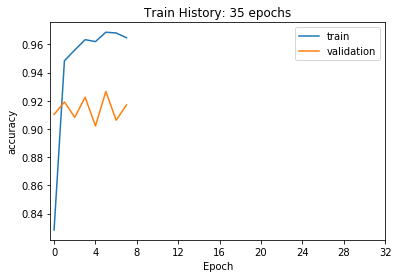

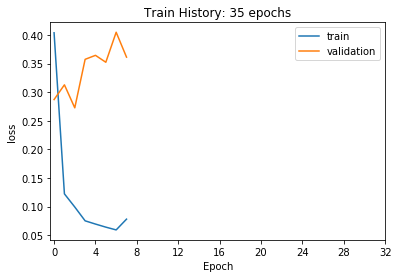

In [24]:
show_train_history(train_history_CNN_LSTM,n_epochs,'accuracy','val_accuracy')
show_train_history(train_history_CNN_LSTM,n_epochs,'loss','val_loss')

This outcome for the training history is challenging to understand at first, since normally an increase in validation loss would be expected to be accompanied by a decrease in validation accuracy. However, that is not the case here as the accuracy stays relatively constant but the loss increases significantly. 

A possible explanation:

Cross entropy is not a bounded loss, meaning that a few "very" wrong predictions can potentially make the loss grow very quickly. It is possible that there are a few outliers that are classified extremely badly and that are making the loss explode, but the model is still learning on the rest of the dataset and continuing to correctly predict the other samples consistently.

The growing loss could be a combination of 2 competing phenomena:

- Some examples with borderline predictions get predicted better and so their output class changes (e.g. a SITTING sample predicted at 0.4 to be SITTING and 0.6 to STANDING in the next epoch gets predicted at 0.4 to be STANDING and 0.6 to be SITTING). In this case, accuracy increases while loss decreases.

- Some examples with poor predictions keep getting worse (e.g. a SITTING sample predicted at 0.8 to be to be STANDING becomes predicted at 0.9 to be STANDING) and/or, potentially more probable for multi-class problems, some examples with very good predictions get a little worse (e.g. a SITTING sample predicted at 0.9 to be SITTING becomes predicted at 0.8 to be SITTING). In this case, loss increases while accuracy stays the same.

If the second case occurs on lots of examples (e.g. for a specific class which is not well captured by the model, such as SITTING or WALKING classes) and cannot be compensated enough by the first case, then the loss will continually increase.

Several attempts at creating a converging or decreasing loss were attempted, with no success for this particular model architecture:

- increasing the number of epochs
- decreasing the batch size
- decreasing and increasing the "step" (subsequence) length

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# evaluate model on test set using .predict() and then revert to integer class label encoding
start_time = time.time()
y_test_pred_encoded = CNN_LSTM_model.predict(X_test_reshaped)
print("--- CNN-LSTM model prediction executed in %s seconds ---" % (time.time() - start_time))
y_test_pred = np.argmax(y_test_pred_encoded, axis =1)
y_test_act = np.argmax(y_test, axis =1)

labels = ['LAY', 'SIT', 'STA', 'WALK', 'WALK_D', 'WALK_U']
print('Confusion matrix for CNN-LSTM evaluation on test set:\n')
print(labeled_confusion_mat(y_test_act, y_test_pred, labels))
print('\nClassification report for CNN-LSTM evaluation on test set:\n')
print(classification_report(y_test_act, y_test_pred, target_names=labels))

--- CNN-LSTM model prediction executed in 0.7380580902099609 seconds ---
Confusion matrix for CNN-LSTM evaluation on test set:

        LAY  SIT  STA  WALK  WALK_D  WALK_U
LAY     432   32   31     1       0       0
SIT       0  455   16     0       0       0
STA       0   32  388     0       0       0
WALK      0    3    0   428      60       0
WALK_D    0    3    0   115     414       0
WALK_U    0   41    0     0       0     496

Classification report for CNN-LSTM evaluation on test set:

              precision    recall  f1-score   support

         LAY       1.00      0.87      0.93       496
         SIT       0.80      0.97      0.88       471
         STA       0.89      0.92      0.91       420
        WALK       0.79      0.87      0.83       491
      WALK_D       0.87      0.78      0.82       532
      WALK_U       1.00      0.92      0.96       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg   

In [26]:
evaluate_model(CNN_LSTM_model, repeats=10)

Train on 5881 samples, validate on 1471 samples
Epoch 1/35
5881/5881 [==============================] - 4s 626us/sample - loss: 0.0895 - accuracy: 0.9589 - val_loss: 0.3044 - val_accuracy: 0.9273
Epoch 2/35
5881/5881 [==============================] - 4s 627us/sample - loss: 0.0657 - accuracy: 0.9706 - val_loss: 0.3241 - val_accuracy: 0.9381
Epoch 3/35
5881/5881 [==============================] - 4s 627us/sample - loss: 0.0567 - accuracy: 0.9719 - val_loss: 0.3946 - val_accuracy: 0.9211
Epoch 4/35
5881/5881 [==============================] - 4s 627us/sample - loss: 0.0476 - accuracy: 0.9750 - val_loss: 0.4423 - val_accuracy: 0.9218
Epoch 5/35
5881/5881 [==============================] - 4s 624us/sample - loss: 0.0488 - accuracy: 0.9760 - val_loss: 0.3402 - val_accuracy: 0.9327
Epoch 6/35
5881/5881 [==============================] - 4s 630us/sample - loss: 0.0511 - accuracy: 0.9764 - val_loss: 0.3977 - val_accuracy: 0.9239
Epoch 00006: early stopping
>#1: 0.887
Train on 5881 samples, va

5881/5881 [==============================] - 4s 644us/sample - loss: 2.4574e-05 - accuracy: 1.0000 - val_loss: 0.7815 - val_accuracy: 0.9395
Epoch 3/35
5881/5881 [==============================] - 4s 624us/sample - loss: 1.6448e-05 - accuracy: 1.0000 - val_loss: 0.7933 - val_accuracy: 0.9395
Epoch 4/35
5881/5881 [==============================] - 4s 625us/sample - loss: 1.6985e-05 - accuracy: 1.0000 - val_loss: 0.8044 - val_accuracy: 0.9395
Epoch 5/35
5881/5881 [==============================] - 4s 625us/sample - loss: 1.6603e-05 - accuracy: 1.0000 - val_loss: 0.8208 - val_accuracy: 0.9388
Epoch 6/35
5881/5881 [==============================] - 4s 625us/sample - loss: 9.2877e-06 - accuracy: 1.0000 - val_loss: 0.8479 - val_accuracy: 0.9395
Epoch 00006: early stopping
>#7: 0.929
Train on 5881 samples, validate on 1471 samples
Epoch 1/35
5881/5881 [==============================] - 4s 624us/sample - loss: 7.7460e-06 - accuracy: 1.0000 - val_loss: 0.8543 - val_accuracy: 0.9388
Epoch 2/35
5

__ConvLSTM Model__

The ConvLSTM is similar in function to the CNN-LSTM. In ConvLSTM, the matrix multiplication calculation of the input with the LSTM cell is replaced by a convolution operation; the convolution is essentially embedded in the architecture. In contrast, CNN-LSTM architecture concatenates the CNN and LSTM architectures together externally.

Again, the model architecture will be defined in a function and a grid search used to evaluate hyperparameter combinations to optimize the model. Then the model with the best parameter combination will be fit to the training dataset and evaluated on the test dataset.

In [27]:
# Use scikit-learn to grid search the network hyperparameters
from tensorflow.keras.layers import ConvLSTM2D

# Define key array lengths 
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], n_steps, 1, n_length, n_features))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], n_steps, 1, n_length, n_features))

# Function to create model, required for KerasClassifier
def create_ConvLSTM_model(neurons=100, dropout=0.5, batch_size=64):
    
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(neurons, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [28]:
# create model with early stopping monitor (if model convergence reached before n_epochs)
ConvLSTM_model = KerasClassifier(build_fn=create_ConvLSTM_model, verbose=0, epochs=n_epochs)

# run grid search and report results and early stopping
ConvLSTM_grid = GridSearchCV(estimator=ConvLSTM_model, param_grid=param_grid, cv=3, verbose=1, n_jobs=1)

In [30]:
# load grid search results from file if previously run (to avoid long runtime)
if os.path.exists('..\data\interim\ConvLSTM_grid_result_best_score_.pickle'):
    with open('..\data\interim\ConvLSTM_grid_result_best_score_.pickle', 'rb') as f:
        ConvLSTM_grid_result_best_score_ = pickle.load(f)
    with open('..\data\interim\ConvLSTM_grid_result_best_params_.pickle', 'rb') as f:
        ConvLSTM_grid_result_best_params_ = pickle.load(f)
    with open('..\data\interim\ConvLSTM_grid_result_cv_results_.pickle', 'rb') as f:
        ConvLSTM_grid_result_cv_results_ = pickle.load(f)
else:
    # fit the grid search models, report results with early stopping callback, and pickle the result
    # note: grid_result itself cannot be pickled, so it must be broken down to subvariables and pickled 
    ConvLSTM_grid_result = ConvLSTM_grid.fit(X_train_reshaped, y_train, validation_split=0.20, callbacks=[es])
    
    with open('..\data\interim\ConvLSTM_grid_result_best_score_.pickle', 'wb') as f:
        pickle.dump(ConvLSTM_grid_result.best_score_, f)
    with open('..\data\interim\ConvLSTM_grid_result_best_params_.pickle', 'wb') as f:
        pickle.dump(ConvLSTM_grid_result.best_params_, f)
    with open('..\data\interim\ConvLSTM_grid_result_cv_results_.pickle', 'wb') as f:
        pickle.dump(ConvLSTM_grid_result.cv_results_, f)
    
    CNN_LSTM_grid_result_best_score_ = ConvLSTM_grid_result.best_score_ 
    CNN_LSTM_grid_result_best_params_ = ConvLSTM_grid_result.best_params_
    CNN_LSTM_grid_result_cv_results_ = ConvLSTM_grid_result.cv_results_

In [31]:
# summarize results
print("Best: %f using %s" % (ConvLSTM_grid_result_best_score_, ConvLSTM_grid_result_best_params_))
means = ConvLSTM_grid_result_cv_results_['mean_test_score']
stds = ConvLSTM_grid_result_cv_results_['std_test_score']
params = ConvLSTM_grid_result_cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.929813 using {'batch_size': 128, 'dropout': 0.3, 'neurons': 50}
0.921242 (0.020680) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 50}
0.921924 (0.016297) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 100}
0.909139 (0.029201) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 200}
0.918388 (0.019934) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 50}
0.919748 (0.020833) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 100}
0.921109 (0.009027) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 200}
0.920563 (0.017669) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 50}
0.925189 (0.021206) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 100}
0.917846 (0.025003) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 200}
0.909275 (0.019307) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 50}
0.919614 (0.023501) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 100}
0.921244 (0.013299) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 200}
0.922467

In [32]:
# initialize a model with the best parameters from the grid search
start_time = time.time()
ConvLSTM_model = create_ConvLSTM_model(neurons=ConvLSTM_grid_result_best_params_['neurons'], 
                      dropout=ConvLSTM_grid_result_best_params_['dropout'], 
                      batch_size=ConvLSTM_grid_result_best_params_['batch_size'])

# show a summary of the model network architechture and output shape from each layer
print(ConvLSTM_model.summary())

# fit the model and output the training history so it may be plotted
ConvLSTM_train_history = ConvLSTM_model.fit(x=X_train_reshaped, y=y_train,  
                          validation_split=0.20, 
                          epochs=n_epochs, 
                          batch_size=ConvLSTM_grid_result_best_params_['batch_size'], 
                          verbose=2,
                          callbacks=[es])

print("\n--- Training executed in %s seconds ---" % (time.time() - start_time))

Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_82 (ConvLSTM2D) (None, 1, 30, 64)         56320     
_________________________________________________________________
dropout_85 (Dropout)         (None, 1, 30, 64)         0         
_________________________________________________________________
flatten_83 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_168 (Dense)            (None, 50)                96050     
_________________________________________________________________
dense_169 (Dense)            (None, 6)                 306       
Total params: 152,676
Trainable params: 152,676
Non-trainable params: 0
_________________________________________________________________
None
Train on 5881 samples, validate on 1471 samples
Epoch 1/35
5881/5881 - 6s - loss: 0.7537 - accuracy: 0.6994 

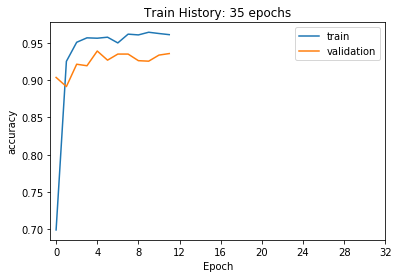

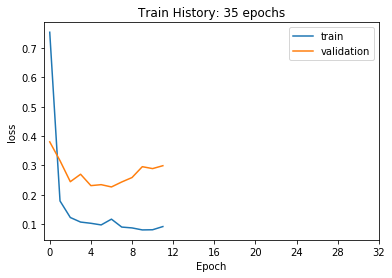

In [33]:
show_train_history(ConvLSTM_train_history,n_epochs,'accuracy','val_accuracy')
show_train_history(ConvLSTM_train_history,n_epochs,'loss','val_loss')

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# evaluate model on test set using .predict() and then revert to integer class label encoding

start_time = time.time()
y_test_pred_encoded = ConvLSTM_model.predict(X_test_reshaped)
print("--- ConvLSTM model prediction executed in %s seconds ---" % (time.time() - start_time))
y_test_pred = np.argmax(y_test_pred_encoded, axis =1)
y_test_act = np.argmax(y_test, axis =1)

labels = ['LAY', 'SIT', 'STA', 'WALK', 'WALK_D', 'WALK_U']
print('\nConfusion matrix for ConvLSTM evaluation on test set:\n')
print(labeled_confusion_mat(y_test_act, y_test_pred, labels))
print('\nClassification report for ConvLSTM evaluation on test set:\n')
print(classification_report(y_test_act, y_test_pred, target_names=labels))

--- ConvLSTM model prediction executed in 0.638293981552124 seconds ---

Confusion matrix for ConvLSTM evaluation on test set:

        LAY  SIT  STA  WALK  WALK_D  WALK_U
LAY     472    6   18     0       0       0
SIT       8  446   17     0       0       0
STA       2   18  400     0       0       0
WALK      0   10    0   399      82       0
WALK_D    0    0    0    76     456       0
WALK_U    0   27    0     0       0     510

Classification report for ConvLSTM evaluation on test set:

              precision    recall  f1-score   support

         LAY       0.98      0.95      0.97       496
         SIT       0.88      0.95      0.91       471
         STA       0.92      0.95      0.94       420
        WALK       0.84      0.81      0.83       491
      WALK_D       0.85      0.86      0.85       532
      WALK_U       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.91      0.91      0.91      2947
weighted avg   

In [35]:
evaluate_model(ConvLSTM_model, repeats=10)

Train on 5881 samples, validate on 1471 samples
Epoch 1/35
5881/5881 [==============================] - 4s 751us/sample - loss: 0.1070 - accuracy: 0.9541 - val_loss: 0.3012 - val_accuracy: 0.9048
Epoch 2/35
5881/5881 [==============================] - 5s 771us/sample - loss: 0.0835 - accuracy: 0.9621 - val_loss: 0.3199 - val_accuracy: 0.9218
Epoch 3/35
5881/5881 [==============================] - 4s 747us/sample - loss: 0.0803 - accuracy: 0.9621 - val_loss: 0.2976 - val_accuracy: 0.9245
Epoch 4/35
5881/5881 [==============================] - 4s 749us/sample - loss: 0.0972 - accuracy: 0.9587 - val_loss: 0.2958 - val_accuracy: 0.9347
Epoch 5/35
5881/5881 [==============================] - 4s 744us/sample - loss: 0.0743 - accuracy: 0.9650 - val_loss: 0.3439 - val_accuracy: 0.9232
Epoch 6/35
5881/5881 [==============================] - 4s 748us/sample - loss: 0.0644 - accuracy: 0.9680 - val_loss: 0.3471 - val_accuracy: 0.9286
Epoch 7/35
5881/5881 [==============================] - 4s 744us

5881/5881 [==============================] - 4s 745us/sample - loss: 0.0120 - accuracy: 0.9954 - val_loss: 0.9743 - val_accuracy: 0.9341
Epoch 7/35
5881/5881 [==============================] - 4s 759us/sample - loss: 0.0101 - accuracy: 0.9968 - val_loss: 0.9063 - val_accuracy: 0.9320
Epoch 00007: early stopping
>#7: 0.930
Train on 5881 samples, validate on 1471 samples
Epoch 1/35
5881/5881 [==============================] - 4s 750us/sample - loss: 0.0081 - accuracy: 0.9966 - val_loss: 0.9050 - val_accuracy: 0.9361
Epoch 2/35
5881/5881 [==============================] - 4s 751us/sample - loss: 0.0136 - accuracy: 0.9949 - val_loss: 1.0795 - val_accuracy: 0.9361
Epoch 3/35
5881/5881 [==============================] - 4s 744us/sample - loss: 0.0159 - accuracy: 0.9947 - val_loss: 0.9341 - val_accuracy: 0.9334
Epoch 4/35
5881/5881 [==============================] - 4s 743us/sample - loss: 0.0063 - accuracy: 0.9974 - val_loss: 1.0140 - val_accuracy: 0.9347
Epoch 5/35
5881/5881 [==============

Both the CNN-LSTM and ConvLSTM performed approximately the same, and not much better than the LSTM alone for this classification problem. None of the deep learning models implemented on the raw data were able to outperform the SVM baseline on the feature engineered data. However, their strong performance on the raw data is impressive given the knowledge required to perform the original feature engineering.